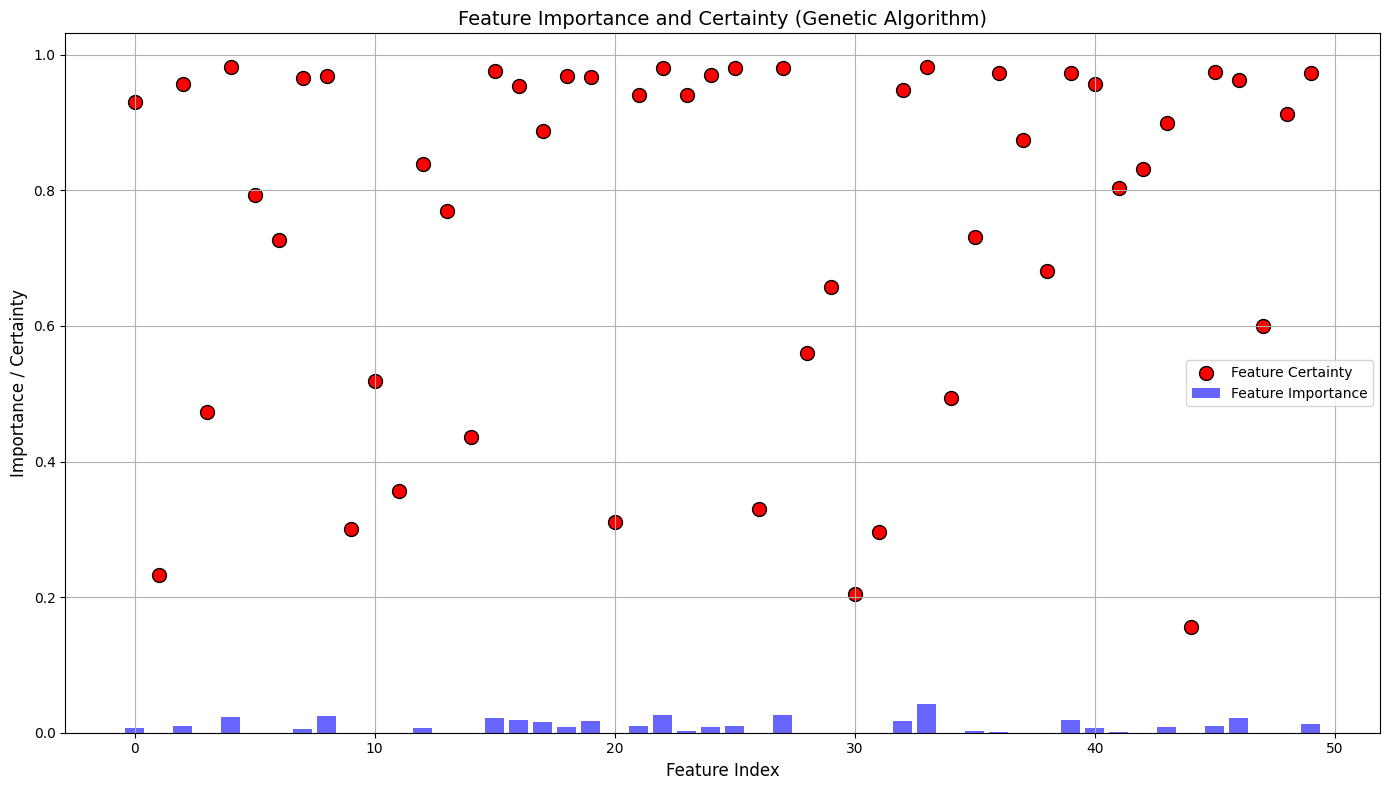

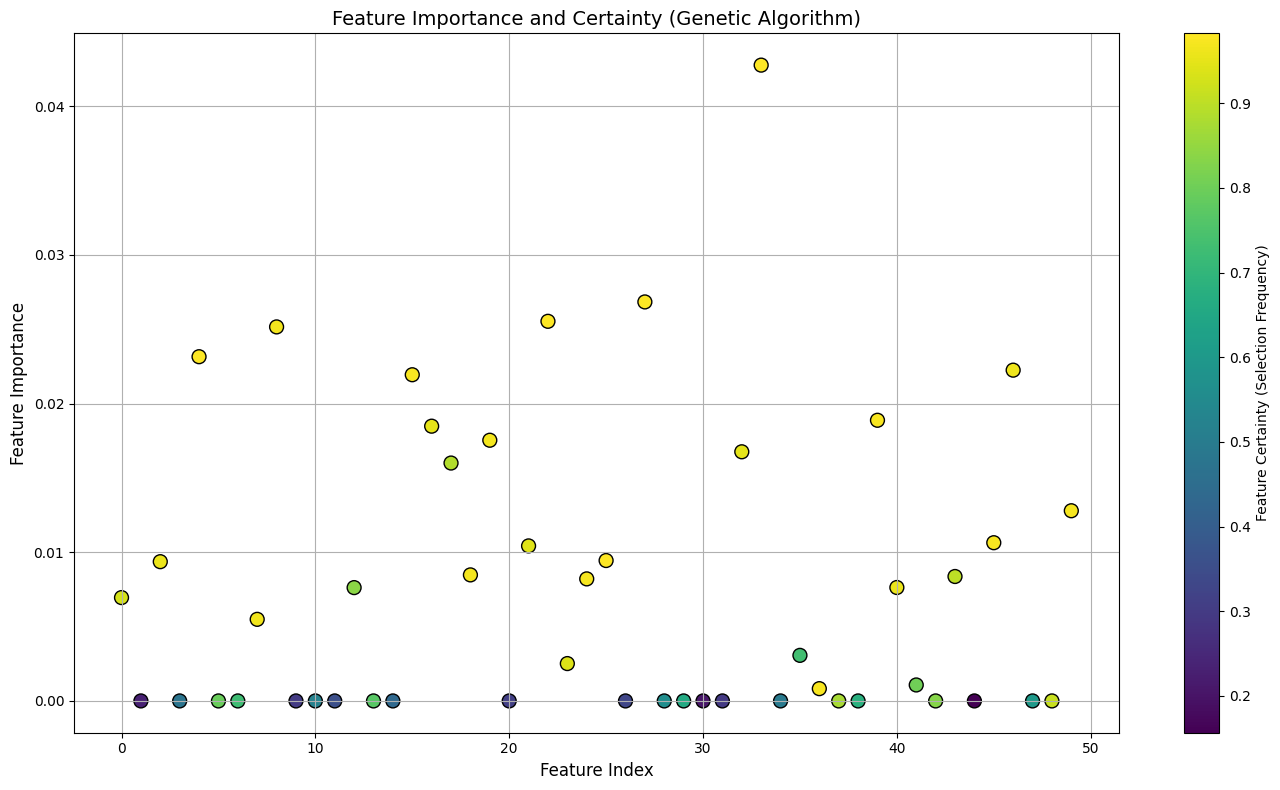

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import check_X_y
from sklearn.base import BaseEstimator

class GeneticAlgorithmModel(BaseEstimator):
    """
    Genetic Algorithm for feature selection.
    Tracks feature importance and selection frequency across generations.
    """
    def __init__(self, n_generations=100, population_size=50, mutation_rate=0.01, crossover_rate=0.8):
        self.n_generations = n_generations
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.feature_importances_ = None  # Feature importance (mutual information)
        self.best_chromosome = None  # Best chromosome (feature mask)
        self.history = []  # Tracks number of active features over generations
        self.feature_selection_frequency_ = None  # Tracks how often each feature is selected

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n_features = X.shape[1]

        # Initialize population with random chromosomes (binary feature masks)
        self.population = np.random.randint(2, size=(self.population_size, n_features)).astype(bool)

        # Initialize feature selection frequency tracker
        self.feature_selection_frequency_ = np.zeros(n_features)

        # Calculate initial feature importance (mutual information)
        mi = mutual_info_classif(X, y)
        self.feature_importances_ = mi

        # Evolve over generations
        for gen in range(self.n_generations):
            # Calculate fitness for each chromosome
            fitness = self._calculate_fitness(X, y, mi)

            # Select the best chromosome for tracking
            best_index = np.argmax(fitness)
            self.best_chromosome = self.population[best_index]
            self.history.append(np.sum(self.best_chromosome))

            # Update feature selection frequency
            self.feature_selection_frequency_ += np.sum(self.population, axis=0)

            # Selection (Tournament selection)
            new_population = self._select(fitness)

            # Crossover
            new_population = self._crossover(new_population)

            # Mutation
            new_population = self._mutate(new_population)

            # Update population
            self.population = new_population

        # Normalize feature selection frequency
        self.feature_selection_frequency_ /= (self.n_generations * self.population_size)

        return self

    def _calculate_fitness(self, X, y, mi):
        # Fitness is the sum of mutual information for selected features
        return [np.sum(mi[chromosome]) for chromosome in self.population]

    def _select(self, fitness):
        # Tournament selection
        new_population = []
        for _ in range(self.population_size):
            # Select 3 random chromosomes
            tournament = np.random.choice(len(fitness), 3, replace=False)
            winner = tournament[np.argmax([fitness[i] for i in tournament])]
            new_population.append(self.population[winner].copy())
        return np.array(new_population)

    def _crossover(self, population):
        # Single-point crossover
        offspring = []
        for i in range(0, self.population_size, 2):
            if np.random.rand() < self.crossover_rate:
                parent1, parent2 = population[i], population[i+1 if i+1 < self.population_size else 0]
                crossover_point = np.random.randint(1, len(parent1))
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
                offspring.extend([child1, child2])
            else:
                offspring.extend([population[i], population[i+1 if i+1 < self.population_size else 0]])
        return np.array(offspring)

    def _mutate(self, population):
        # Bit-flip mutation
        for i in range(len(population)):
            for j in range(len(population[i])):
                if np.random.rand() < self.mutation_rate:
                    population[i][j] = not population[i][j]
        return population

    def get_adc_over_generations(self, n_features):
        # Calculate Active Data Consideration (ADC) over generations
        return [(active / n_features) * 100 for active in self.history]


# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=50, n_informative=30, n_redundant=10, random_state=42)
X = np.abs(X)  # Ensure data is non-negative for mutual information

# Initialize and train the Genetic Algorithm model
ga_model = GeneticAlgorithmModel(n_generations=100, population_size=50, mutation_rate=0.01, crossover_rate=0.8)
ga_model.fit(X, y)

# Get feature importance and selection frequency
feature_importance = ga_model.feature_importances_
feature_certainty = ga_model.feature_selection_frequency_

# Plot Feature Importance and Certainty
plt.figure(figsize=(14, 8))
plt.bar(range(len(feature_importance)), feature_importance, color='blue', alpha=0.6, label='Feature Importance')
plt.scatter(range(len(feature_certainty)), feature_certainty, color='red', label='Feature Certainty', s=100, edgecolor='black')
plt.title("Feature Importance and Certainty (Genetic Algorithm)", fontsize=14)
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Importance / Certainty", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Combine Importance and Certainty in a Single Plot
plt.figure(figsize=(14, 8))
plt.scatter(range(len(feature_importance)), feature_importance, c=feature_certainty, cmap='viridis', s=100, edgecolor='black')
plt.colorbar(label='Feature Certainty (Selection Frequency)')
plt.title("Feature Importance and Certainty (Genetic Algorithm)", fontsize=14)
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Feature Importance", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

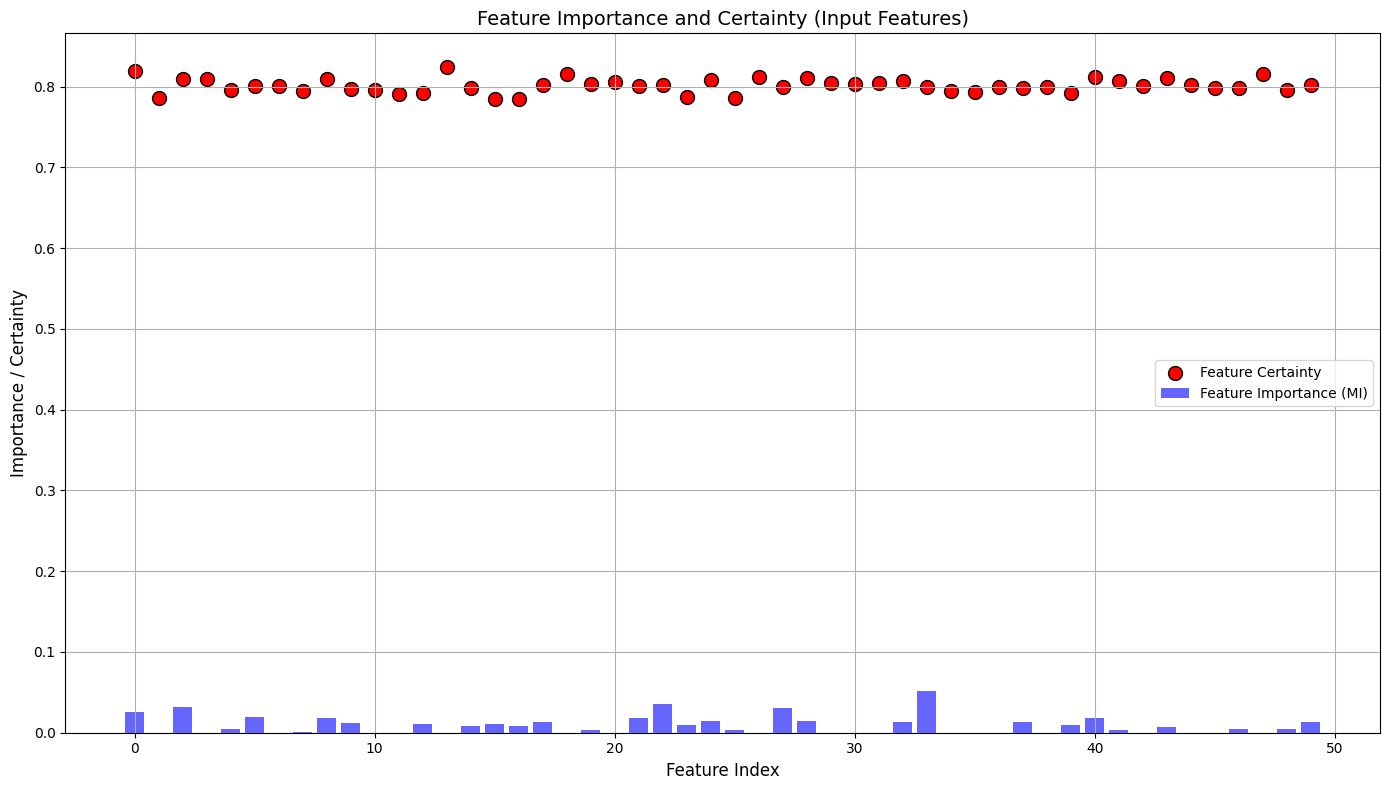

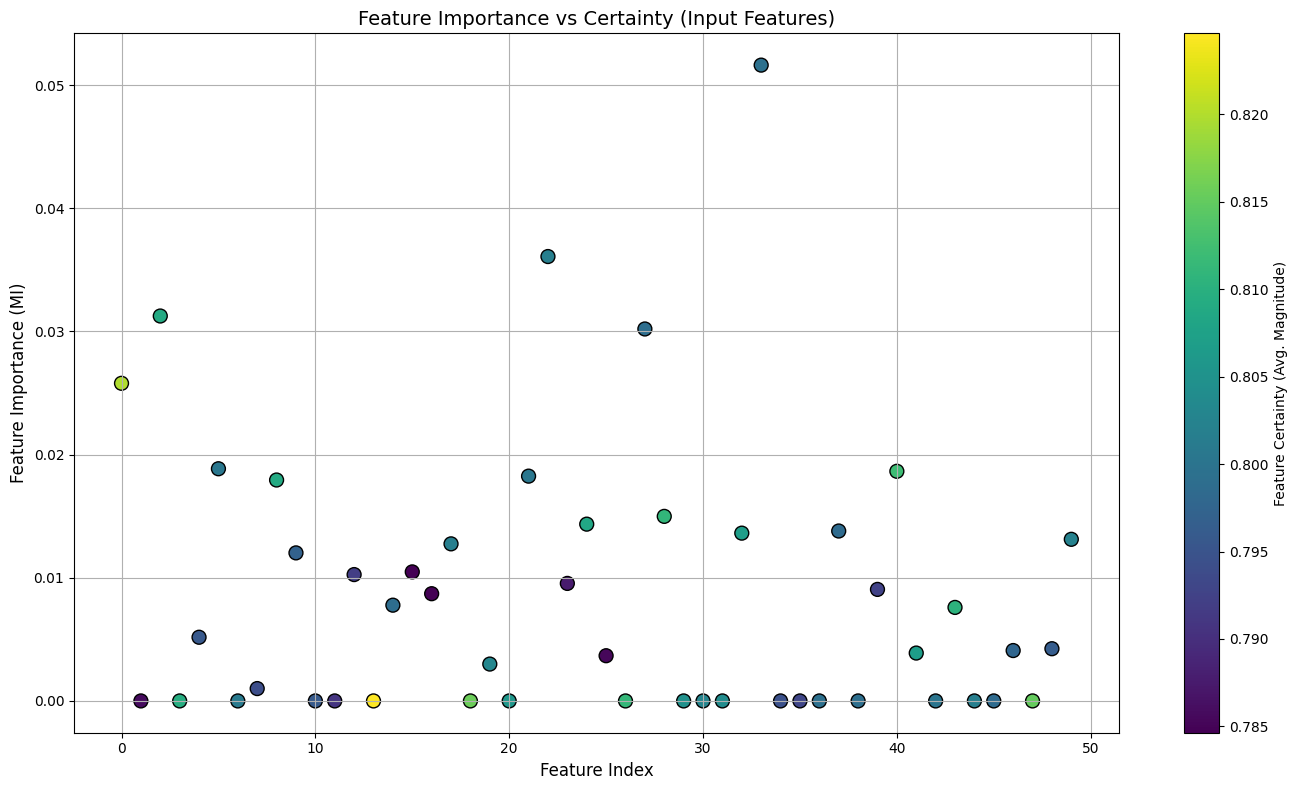

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=50, n_informative=30, n_redundant=10, random_state=42)
X = np.abs(X)  # Ensure non-negative for MI
y_cat = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for CNN (samples, time steps, channels)
X_train_reshaped = X_train[..., np.newaxis]
X_test_reshaped = X_test[..., np.newaxis]

# CNN Model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))
conv_layer = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer)
flatten_layer = Flatten()(conv_layer)
dense_layer = Dense(32, activation='relu')(flatten_layer)
output_layer = Dense(y_cat.shape[1], activation='softmax')(dense_layer)

cnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=0)

# === Feature Importance on original input ===
mi_scores = mutual_info_classif(X_train, np.argmax(y_train, axis=1))

# === Feature Certainty: Average absolute value of each input feature ===
feature_certainty = np.mean(np.abs(X_train), axis=0)

# === Plot: Bar for MI + Scatter for Certainty ===
plt.figure(figsize=(14, 8))
plt.bar(range(len(mi_scores)), mi_scores, color='blue', alpha=0.6, label='Feature Importance (MI)')
plt.scatter(range(len(feature_certainty)), feature_certainty, color='red', label='Feature Certainty', s=100, edgecolor='black')
plt.title("Feature Importance and Certainty (Input Features)", fontsize=14)
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Importance / Certainty", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Scatter Plot: Certainty as color ===
plt.figure(figsize=(14, 8))
plt.scatter(range(len(mi_scores)), mi_scores, c=feature_certainty, cmap='viridis', s=100, edgecolor='black')
plt.colorbar(label='Feature Certainty (Avg. Magnitude)')
plt.title("Feature Importance vs Certainty (Input Features)", fontsize=14)
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Feature Importance (MI)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample predictions: [[0.6188747  0.3811252 ]
 [0.52308017 0.47691992]
 [0.34795785 0.6520421 ]
 [0.4999252  0.50007474]
 [0.52250767 0.4774924 ]]
Prediction range: 0.054547854 0.94545203


  0%|          | 0/50 [00:00<?, ?it/s]

Number of SHAP value arrays: 50
Shape of each SHAP value array: [(50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2), (50, 2)]
Sample SHAP values (first array, first sample): [0. 0.]
Shape of shap_values_total: (50, 50)
Shape of shap_mean_importance: (50,)
SHAP Mean Importance Values: [0.00344074 0.02552117 0.0038658  0.00357374 0.02411628 0.01848697
 0.00384256 0.00135976 0.00340625 0.00364673 0.00275455 0.00085044
 0.00466251 0.0049212  0.00265534 0.00287293 0.00147077 0.00820214
 0.00882164 0.01916721 0.00690686 0.00691511 0.00922528 0.0077951
 0.00396965 0.00229475 0.0023689  0.00676175 0.00350818 0.0

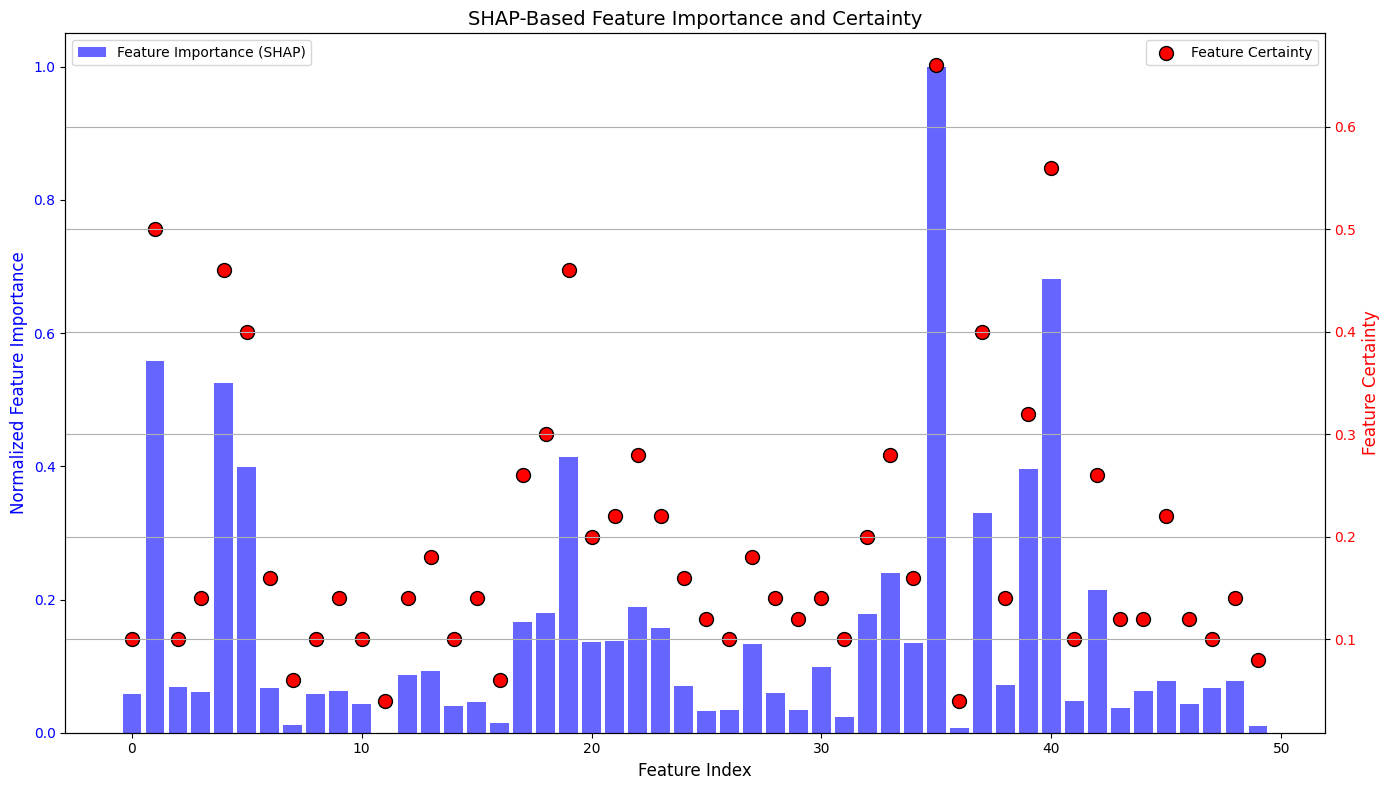

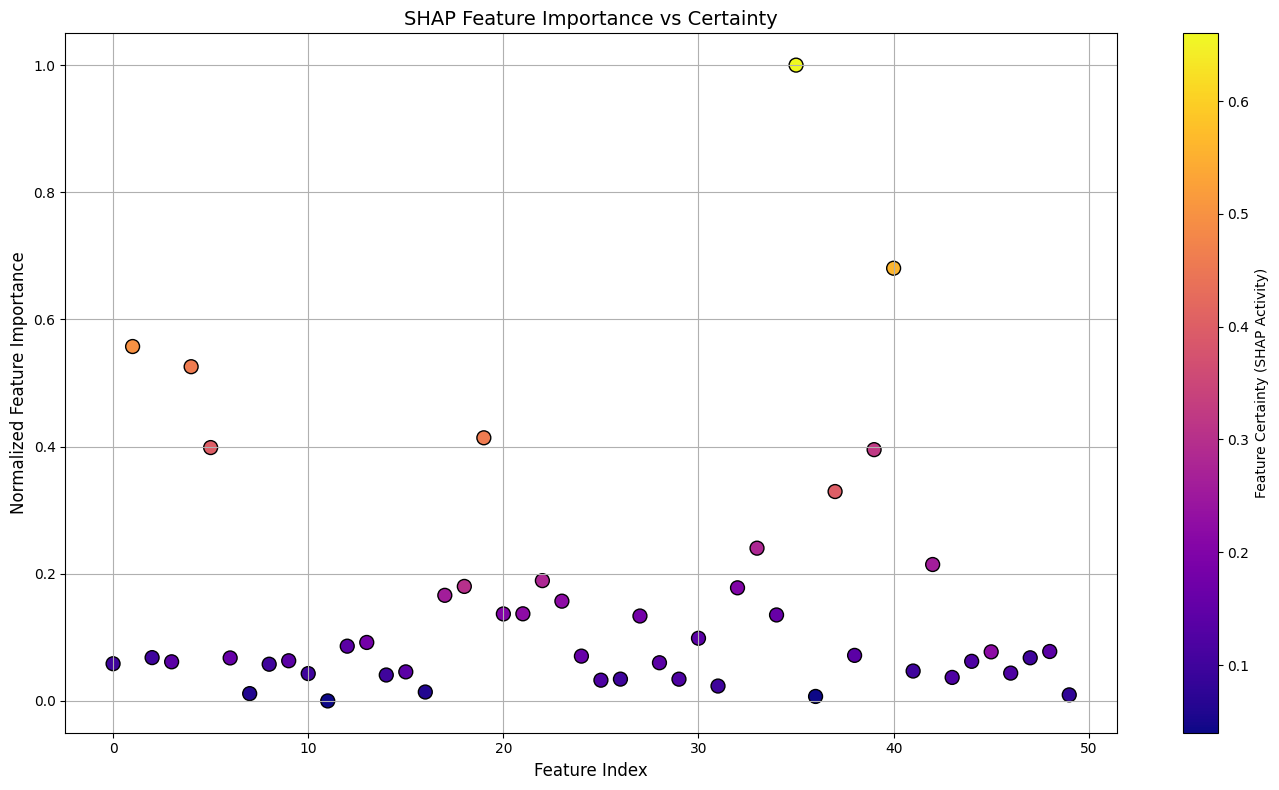

<ipython-input-15-bad75f35b5b6>:125: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_total, X_test_2d[:n_samples], plot_type="bar", show=False)


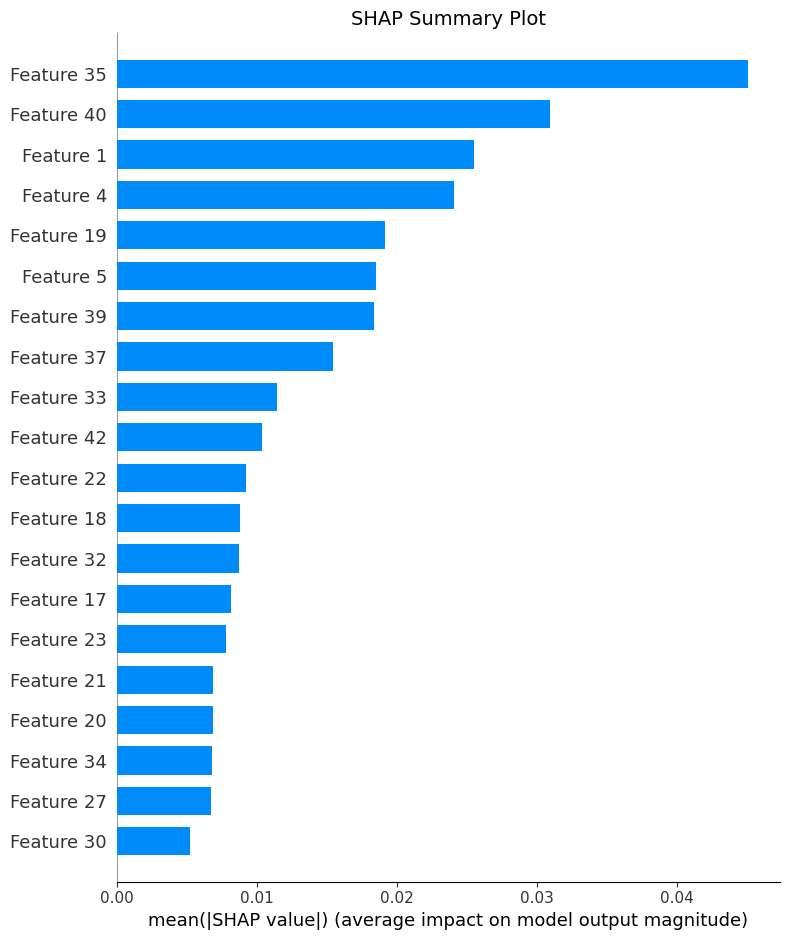

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from sklearn.datasets import make_classification
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate dataset
X, y = make_classification(n_samples=1000, n_features=50, n_informative=30, n_redundant=10, random_state=42)
X = np.abs(X)
y_cat = to_categorical(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use 2D input
X_train_2d = X_train_scaled  # shape: (800, 50)
X_test_2d = X_test_scaled    # shape: (200, 50)

# Build dense model
input_layer = Input(shape=(X_train_2d.shape[1],))
dense = Dense(32, activation='relu')(input_layer)
output = Dense(y_cat.shape[1], activation='softmax')(dense)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_2d, y_train, epochs=10, batch_size=32, verbose=0)

# Verify model predictions
predictions = model.predict(X_test_2d[:200])
print("Sample predictions:", predictions[:5])
print("Prediction range:", predictions.min(), predictions.max())

# --- SHAP analysis with KernelExplainer ---
def model_predict(inputs):
    return model.predict(inputs, verbose=0)

# Use a smaller background set for speed
background = X_train_2d[:50]
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values
n_samples = 50
shap_values = explainer.shap_values(X_test_2d[:n_samples], nsamples=100)

# Debug: Inspect SHAP values
print("Number of SHAP value arrays:", len(shap_values))
print("Shape of each SHAP value array:", [v.shape for v in shap_values])
if len(shap_values) > 0:
    print("Sample SHAP values (first array, first sample):", shap_values[0][0])

# Manually adjust SHAP values for multi-output model
# shap_values is a list of n_samples arrays, each (50, 2). We need (n_samples, 50) for the predicted class.
predictions = model.predict(X_test_2d[:n_samples], verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
shap_values_total = np.zeros((n_samples, 50))
for i in range(n_samples):
    shap_values_total[i] = shap_values[i][:, predicted_classes[i]]  # Select SHAP values for predicted class

# Debug: Inspect adjusted SHAP values
print("Shape of shap_values_total:", shap_values_total.shape)

# Average over samples to get feature importance
shap_mean_importance = np.mean(np.abs(shap_values_total), axis=0)  # shape: (50,)
print("Shape of shap_mean_importance:", shap_mean_importance.shape)
print("SHAP Mean Importance Values:", shap_mean_importance)
print("SHAP Mean Importance Range:", shap_mean_importance.min(), shap_mean_importance.max())

# Feature certainty: fraction of non-zero SHAP values
non_zero_counts = np.count_nonzero(shap_values_total, axis=0)
feature_certainty = non_zero_counts / shap_values_total.shape[0]  # shape: (50,)
print("Shape of feature_certainty:", feature_certainty.shape)
print("Feature Certainty Values:", feature_certainty)
print("Feature Certainty Range:", feature_certainty.min(), feature_certainty.max())

# Normalize shap_mean_importance for plotting
if shap_mean_importance.max() > shap_mean_importance.min():
    shap_mean_importance_normalized = (shap_mean_importance - shap_mean_importance.min()) / (shap_mean_importance.max() - shap_mean_importance.min())
else:
    shap_mean_importance_normalized = np.zeros_like(shap_mean_importance)
print("Normalized SHAP Mean Importance:", shap_mean_importance_normalized)

# --- Plot 1: Bar + Certainty with Twin Axis ---
plt.figure(figsize=(14, 8))
ax1 = plt.gca()
ax1.bar(range(50), shap_mean_importance_normalized, color='blue', alpha=0.6, label='Feature Importance (SHAP)')
ax1.set_xlabel("Feature Index", fontsize=12)
ax1.set_ylabel("Normalized Feature Importance", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.scatter(range(50), feature_certainty, color='red', label='Feature Certainty', s=100, edgecolor='black')
ax2.set_ylabel("Feature Certainty", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("SHAP-Based Feature Importance and Certainty", fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Colored Scatter ---
plt.figure(figsize=(14, 8))
plt.scatter(range(50), shap_mean_importance_normalized, c=feature_certainty, cmap='plasma', s=100, edgecolor='black')
plt.colorbar(label='Feature Certainty (SHAP Activity)')
plt.title("SHAP Feature Importance vs Certainty", fontsize=14)
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Normalized Feature Importance", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SHAP Summary Plot ---
shap.summary_plot(shap_values_total, X_test_2d[:n_samples], plot_type="bar", show=False)
plt.title("SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()